Here we identify a clique to simulate. Then we ablate the network, removing all other neurons outside the clique (with the option to also remove direct connections from sink to source). Then we simulate the network, by inject a current into the source, and see the response in the sink. This activity is then modulated by also injecting currents into various middle neurons.

The network has been created previously. The network synapses are exported using 
```Snudda/snudda/utils/export_connection_matrix.py topology100/network_synapses.hdf5 topology100 test100.csv```

The ```csv``` is then converted to flagser using ```fromcsv2flagser.py```, then ```./flagsercount.py test100.flagser```

In [1]:
import os
os.environ["SNUDDA_DATA"] = "../../../../BasalGangliaData/data/"
assert os.path.isdir(os.getenv("SNUDDA_DATA")), f"You need to have BasalGangliaData installed for this example."

network_path = "topology100"
network_file = os.path.join(network_path, "network-synapses.hdf5")
simplex_file_name = os.path.join(network_path, "topology100_D6_simplices0.simplices")
ablated_network_file = os.path.join(network_path, "network-ablated.hdf5")

remove_sink_to_source_connections = True

In [2]:
from snudda.analyse.analyse_topology import SnuddaAnalyseTopology
sat = SnuddaAnalyseTopology(network_file=network_file)
sat.load_simplex_file(simplex_file_name=simplex_file_name)
mult = sat.get_fixed_multiplicity()

Loading 99 neurons with 6999 synapses and 0 gap junctions
Loading 99 neurons with 6999 synapses and 0 gap junctions
Loaded simplex data of dimension 6 from topology100/topology100_D6_simplices0.simplices


Next in this example we list the cliques with multiplicity 3. To see all of them simply inspect mult[6]. Here the 6 refers to the clique dimension we loaded. You could also load multiple clique dimension files at the same time and compare them.

In [3]:
filt_mult = sat.filter_multiplicity(mult, dimension=6, neuron_type_list=[["FS", 1], ["iSPN", 4]],
                       multiplicity_requirement=None)

In [4]:
filt_mult

OrderedDict([((92, 34, 43, 82, 93, 95, 71), 3),
             ((92, 26, 43, 65, 95, 96, 93), 1),
             ((92, 26, 65, 93, 95, 96, 43), 1),
             ((92, 26, 43, 82, 95, 96, 33), 2)])

In [5]:
selected_clique_neurons = list(filt_mult)[0]

In [6]:
selected_clique_neurons

(92, 34, 43, 82, 93, 95, 71)

### Ablating network

In [7]:
from snudda.utils.ablate_network import SnuddaAblateNetwork
san = SnuddaAblateNetwork(network_file=network_file)
san.only_keep_neuron_id(selected_clique_neurons)

Loading 99 neurons with 6999 synapses and 0 gap junctions


The cell below removes sink to source connections if the ```remove_sink_to_source``` flag is set.

In [8]:
if remove_sink_to_source_connections:
    san.remove_pair_connection(pre_id=selected_clique_neurons[-1], post_id=selected_clique_neurons[0])

Note that the neurons get remapped, when we ablate the network and remove a subset of the neurons.

In [9]:
san.write_network(out_file_name=ablated_network_file, print_remapping=True)

Writing to topology100/network-ablated.hdf5
Copying morphologies
Keeping 7 neurons.

Remapping neurons:
92 -> 0
34 -> 1
43 -> 2
82 -> 3
93 -> 4
95 -> 5
71 -> 6

0/6999 synapses processed
6999/6999 synapses processed
Warning, removing individual synapses (1) can be slow, use this with caution.
Filtering done.
0/0 synapses processed
Warning, removing individual synapses (1) can be slow, use this with caution.
Filtering done.
Copying synapses and gap junctions
0 / 97 synapse rows parsed
6999 / 97 synapse rows parsed
Synapse matrix written.
Keeping 97 synapses (out of 6999)
0 / 0 gap junction rows parsed
Gap junction matrix written.
Keeping 0  gap junctions (out of 0)


### Simulating network

Next step is running the network with current injections (we should also run it with synaptic input).

#### NEED TO CHANGE TO BasalGangliaData

In [10]:
!nrnivmodl $SNUDDA_DATA/neurons/mechanisms

/home/hjorth/HBP/Snudda/examples/notebooks/Topology
Mod files: "../../../../BasalGangliaData/data//neurons/mechanisms/bk_ch.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/bk_fs.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/bk_ms.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/ca_ch.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/cadyn_fs.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/cadyn_ms.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/cal12_ms.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/cal13_ms.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/cal_ch.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/caldyn_ms.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/can_fs.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/can_ms.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/cap_ch.mod" "../../../../BasalGangliaData/data//neurons/mechanisms/caq_

In [11]:
experiment_config_file = "topology_clique_simulation_experiment-6.json"
from snudda.simulate.pair_recording import PairRecording 
pr = PairRecording(network_path=network_path, network_file=ablated_network_file,
                   experiment_config_file=experiment_config_file)

Pair recording output file: topology100/simulation/TCS-output-6.hdf5
Loading 7 neurons with 97 synapses and 0 gap junctions
Setting tmGabaA reversal potential to -65.0 mV


In [12]:
pr.run()

Running simulation for 1.0 s
Running Neuron simulator 1000 ms, with dt=0.025
1% done. Elapsed: 2.4 s, estimated time left: 236.6 s
48% done. Elapsed: 104.1 s, estimated time left: 112.8 s
95% done. Elapsed: 204.2 s, estimated time left: 10.7 s
99% done. Elapsed: 214.7 s, estimated time left: 2.2 s
Neuron simulation finished
Simulation run time: 217.1 s
Writing network output to topology100/simulation/TCS-output-6.hdf5
CHeck why not able to save...
Using sample dt = 0.0005 (sample step size 20)
Worker 1/1 writing data to topology100/simulation/TCS-output-6.hdf5


Loading network info from topology100/network-ablated.hdf5
Loading 7 neurons with 97 synapses and 0 gap junctions
Loading topology100/simulation/TCS-output-6.hdf5
Plotting traces: [0, 1, 2, 3, 4, 5, 6]
Plotted 7 traces (total 7)


<IPython.core.display.Javascript object>


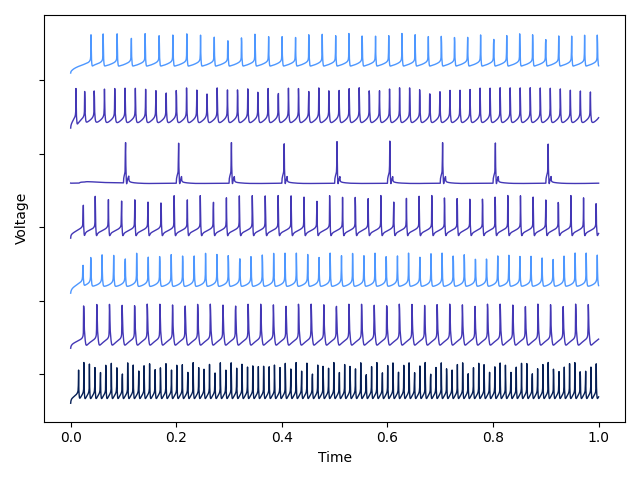

Saving to figure /home/hjorth/HBP/Snudda/examples/notebooks/Topology/topology100/figures/Network-voltage-trace-TopologyClique-6-FS-dSPN-iSPN.pdf


In [13]:
%matplotlib notebook
pr.plot_trace_overview()